In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
inputs = pd.read_pickle("/content/Sampled_inputs1.pck")
labels = pd.read_pickle("/content/Sampled_labels1.pck")

In [ ]:
inputs.shape

(2310, 60, 33)

In [ ]:
inputs = inputs.transpose(0,2,1)
inputs.shape

(2310, 33, 60)

In [ ]:
from collections import Counter
label_count = Counter(labels)
label_count

Counter({0: 385, 1: 770, 2: 385, 3: 385, 4: 385})

In [ ]:
len(labels)

2310

In [ ]:
labels = np.where(labels == 0, 1, labels)
labels = np.where(((labels == 2)|(labels ==3)|(labels ==4)), 0, labels)
print(labels)

[1 1 1 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=42)

In [ ]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [ ]:
from collections import Counter

In [ ]:
recounted = Counter(y_train)
recounted

Counter({0: 858, 1: 874})

In [ ]:
recounted = Counter(y_test)
recounted

Counter({0: 297, 1: 281})

In [ ]:
X_train.shape

(1732, 33, 60)

In [ ]:
X_test.shape

(578, 33, 60)

In [ ]:
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=0, min_delta=1e-4, mode='min')

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

input = Input(shape=(33, 60))
x = Permute((2, 1))(input)
x = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


x = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


x = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling1D()(x)

out = Dense(1, activation='sigmoid')(x)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 60)]          0         
_________________________________________________________________
permute (Permute)            (None, 60, 33)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           33920     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 60, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 256)           164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 256)           1024  

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=80, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1,)

Epoch 1/80
13/13 [==============================] - 7s 455ms/step - loss: 0.6764 - accuracy: 0.6375 - val_loss: 1.3164 - val_accuracy: 0.4713
Epoch 2/80
13/13 [==============================] - 6s 430ms/step - loss: 0.4545 - accuracy: 0.7675 - val_loss: 0.9266 - val_accuracy: 0.5805
Epoch 3/80
13/13 [==============================] - 5s 415ms/step - loss: 0.3790 - accuracy: 0.8243 - val_loss: 0.7361 - val_accuracy: 0.5000
Epoch 4/80
13/13 [==============================] - 5s 408ms/step - loss: 0.3852 - accuracy: 0.8219 - val_loss: 0.8925 - val_accuracy: 0.6667
Epoch 5/80
13/13 [==============================] - 5s 411ms/step - loss: 0.3851 - accuracy: 0.8224 - val_loss: 0.7450 - val_accuracy: 0.6839
Epoch 6/80
13/13 [==============================] - 5s 418ms/step - loss: 0.3938 - accuracy: 0.8205 - val_loss: 0.6096 - val_accuracy: 0.7241
Epoch 7/80
13/13 [==============================] - 5s 406ms/step - loss: 0.3848 - accuracy: 0.8260 - val_loss: 0.6322 - val_accuracy: 0.7299
Epoch 

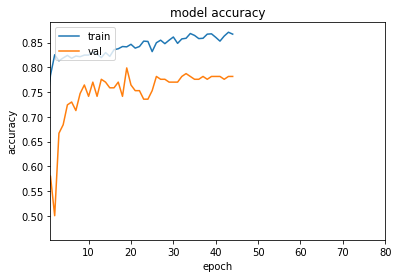

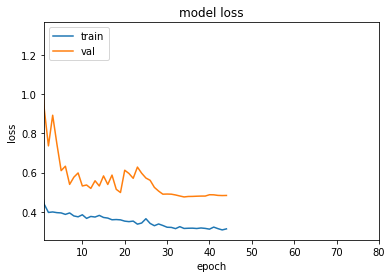

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predict = (model.predict(X_test) > 0.5).astype('int32')

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()
tss = (TP / (TP + FN)) - (FP / (FP + TN))
print("tss: ",tss)

tss:  0.6387960266963826


In [ ]:
target_names =  ['class 0', 'class 1']
print(classification_report(y_test, y_predict, target_names=target_names, digits = 4))

              precision    recall  f1-score   support

     class 0     0.8529    0.7811    0.8155       297
     class 1     0.7876    0.8577    0.8211       281

    accuracy                         0.8183       578
   macro avg     0.8203    0.8194    0.8183       578
weighted avg     0.8212    0.8183    0.8182       578



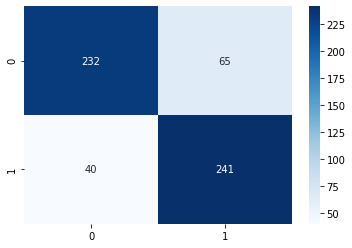

In [ ]:
cm = confusion_matrix(y_test, y_predict)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")

In [ ]:
def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = input.shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

input = Input(shape=(33, 60))
x = Masking()(input)
x = LSTM(8)(x)
x = Dropout(0.8)(x)

y = Permute((2, 1))(input)
y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)


y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)


y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)


y = GlobalAveragePooling1D()(y)
x = concatenate([x, y])

out = Dense(1, activation='sigmoid')(x)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33, 60)]     0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 60, 33)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 60, 128)      33920       permute_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 60, 128)      512         conv1d_3[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=80, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1,)

Epoch 1/80
13/13 [==============================] - 13s 576ms/step - loss: 0.5631 - accuracy: 0.7141 - val_loss: 0.6940 - val_accuracy: 0.4713
Epoch 2/80
13/13 [==============================] - 6s 439ms/step - loss: 0.4350 - accuracy: 0.7874 - val_loss: 0.6526 - val_accuracy: 0.6437
Epoch 3/80
13/13 [==============================] - 6s 442ms/step - loss: 0.3971 - accuracy: 0.8017 - val_loss: 0.6259 - val_accuracy: 0.7241
Epoch 4/80
13/13 [==============================] - 6s 442ms/step - loss: 0.3999 - accuracy: 0.8181 - val_loss: 0.6340 - val_accuracy: 0.7184
Epoch 5/80
13/13 [==============================] - 6s 439ms/step - loss: 0.4228 - accuracy: 0.7913 - val_loss: 0.5634 - val_accuracy: 0.7356
Epoch 6/80
13/13 [==============================] - 6s 447ms/step - loss: 0.3958 - accuracy: 0.8084 - val_loss: 0.5633 - val_accuracy: 0.7299
Epoch 7/80
13/13 [==============================] - 6s 448ms/step - loss: 0.3807 - accuracy: 0.8175 - val_loss: 0.5359 - val_accuracy: 0.7184
Epoch

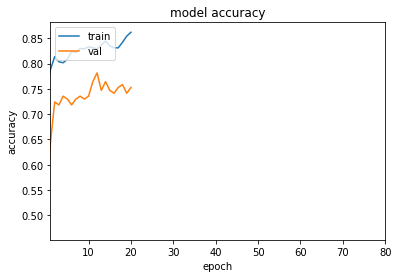

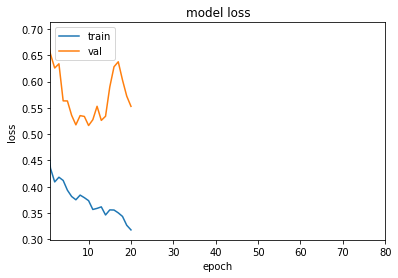

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predict = (model.predict(X_test) > 0.5).astype('int32')

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()
tss = (TP / (TP + FN)) - (FP / (FP + TN))
print("tss: ",tss)

tss:  0.6046586865092203


In [ ]:
from sklearn.metrics import classification_report
target_names =  ['class 0', 'class 1']
print(classification_report(y_test, y_predict, target_names=target_names, digits = 4))

              precision    recall  f1-score   support

     class 0     0.8020    0.8182    0.8100       297
     class 1     0.8036    0.7865    0.7950       281

    accuracy                         0.8028       578
   macro avg     0.8028    0.8023    0.8025       578
weighted avg     0.8028    0.8028    0.8027       578



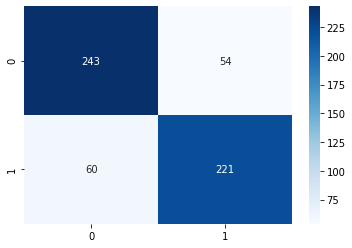

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_predict)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")